In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data/pjt2

/content/drive/MyDrive/data/pjt2


In [ ]:
import pandas as pd
import numpy as np

## 데이터 불러오기

In [ ]:
train = pd.read_csv('data/train_data.csv')
#train = pd.read_csv('data/데이터_추가2_전처리(불용어추가).csv')
test = pd.read_csv('data/test_data.csv')

In [ ]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'title', 'topic_idx', 'data', 'new_title',
       'new_title1', 'new_title2', 'new_title3'],
      dtype='object')

In [ ]:
train.head(2) 
# data : 한자제거 
# data2 : 특수문자 제거
# data_okt : data2 의 okt.morphs
# new_title_600 : data2의 okt+ 불용어 600제거
# new_title_600_stem : data2의 okt + 불용어 600 + stem으로 동사 변환
# new_title_one_word : new_title_600에 한글자제거

,Unnamed: 0,Unnamed: 0.1,title,topic_idx,data,new_title,new_title1,new_title2,new_title3
0,0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천→핀란드 항공기 결항…휴가철 여행객 분통,인천 핀란드 항공기 결항 휴가 철 여행객 분통,인천 핀란드 항공기 결항 휴가 철 여행객 분통,인천 핀란드 항공기 결항 휴가 철 여행객 분통,인천 핀란드 항공기 결항 휴가 여행객 분통
1,1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다…구글 15조원 들여 미국 전역 거점화,실리콘밸리 넘어서다 구글 조원 들이다 미국 전역 거점,실리콘밸리 넘어서다 구글 조원 들이다 미국 전역 거점 화,실리콘밸리 넘어서다 구글 조원 들이다 미국 전역 거점,실리콘밸리 넘어서다 구글 조원 들이다 미국 전역 거점


## XY 나누기

In [ ]:
x_train = train.title
y_train = train.topic_idx
x_test = test.title

## 데이터 확인 및 길이확인

In [ ]:
count = 0
data = []
for i in range(len(x_train)):
  if count <len(x_train[i].split()):
    count = len(x_train[i].split())
    data = x_train[i]
count, data

(14, ' 주중 N 여행 호남권 달빛 가을 벗 삼아 걸어라…한낮 무더위 피해 즐기는 꿀잼 야행')

## 데이터 토크나이져

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

num_word = 0
count = 0

for i in tokenizer.word_counts.values(): # 두번이상 나타난 단어
  if i >=2:
    count +=1
    
num_word = count +2
num_word

t = Tokenizer(num_words= num_word)
t.fit_on_texts(x_train)
s = t.texts_to_sequences(x_train)

s_test = t.texts_to_sequences(x_test)

In [ ]:
x_train[0]

'인천→핀란드 항공기 결항…휴가철 여행객 분통'

In [ ]:
s_test[0]

[1152, 93, 14376, 15011, 48, 3142, 235]

## 데이터 패딩

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(max(len(l) for l in s), max(len(l) for l in s_test))


pad_X_train = pad_sequences(s, maxlen=max_len, padding = 'pre')
pad_X_test = pad_sequences(s_test, maxlen=max_len, padding = 'pre')

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = max_len
pad_X_train = pad_sequences(s, maxlen=max_len, padding = 'pre')
pad_X_test = pad_sequences(s_test, maxlen=max_len, padding = 'pre')

## 모델링

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Dropout

model = Sequential()

# 이 층은 모델의 제일 첫 번째 층으로만 사용할 수 있습니다.
# Flatten 층을 사용하기 위해 input_length를 전달합니다.
model.add(Embedding(input_dim = num_word, output_dim = 32, input_length = max_len)) #max_len 22 

model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 32)            1204224   
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 128)           82432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 14, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [ ]:
from sklearn.model_selection import train_test_split

X_tn, X_tt, y_tn, y_tt = train_test_split(pad_X_train, y_train, test_size=0.33, random_state=2021)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/data/pjt2/model/rnn/rnn_model.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

history = model.fit(X_tn, y_tn, 
                    batch_size = 512, 
                    epochs = 20, 
                    #callbacks=[es, mc],
                    validation_data = (X_tt, y_tt)) # 과적합 발생 

Epoch 1/20
70/70 [==============================] - 8s 76ms/step - loss: 1.8528 - acc: 0.2047 - val_loss: 1.6097 - val_acc: 0.2902
Epoch 2/20
70/70 [==============================] - 5s 67ms/step - loss: 1.4276 - acc: 0.3622 - val_loss: 1.3317 - val_acc: 0.4339
Epoch 3/20
70/70 [==============================] - 5s 71ms/step - loss: 1.1258 - acc: 0.5146 - val_loss: 1.2177 - val_acc: 0.5239
Epoch 4/20
70/70 [==============================] - 5s 68ms/step - loss: 0.7735 - acc: 0.7150 - val_loss: 0.9480 - val_acc: 0.7163
Epoch 5/20
70/70 [==============================] - 5s 69ms/step - loss: 0.4456 - acc: 0.8579 - val_loss: 0.8156 - val_acc: 0.7423
Epoch 6/20
70/70 [==============================] - 5s 70ms/step - loss: 0.2985 - acc: 0.9047 - val_loss: 0.8979 - val_acc: 0.7537
Epoch 7/20
70/70 [==============================] - 5s 71ms/step - loss: 0.2210 - acc: 0.9311 - val_loss: 1.0036 - val_acc: 0.7579
Epoch 8/20
70/70 [==============================] - 5s 70ms/step - loss: 0.1714 - a

## 에폭저장된거 불러옴

In [ ]:
'''
model = Sequential()

# 이 층은 모델의 제일 첫 번째 층으로만 사용할 수 있습니다.
# Flatten 층을 사용하기 위해 input_length를 전달합니다.
model.add(Embedding(input_dim = num_word, output_dim = 32, input_length = max_len)) #max_len 22 

model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

latest = tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(latest)
model.evaluate(pad_X_train, y_train, verbose=2)
'''

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/data/pjt2/model/rnn/rnn_model.h5')
model2.evaluate(pad_X_train, y_train, verbose=2)

1669/1669 - 9s - loss: 0.4624 - acc: 0.8633


[0.4623856842517853, 0.8633222579956055]

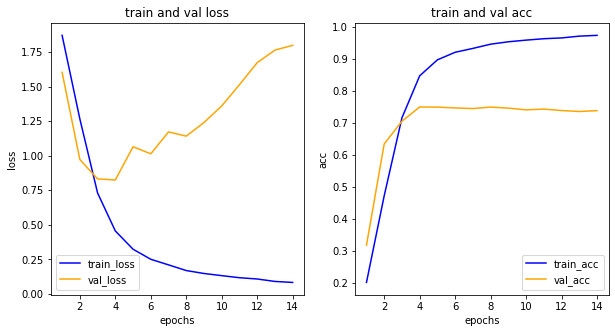

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## 예측

In [ ]:
pre =model2.predict(pad_X_test)

In [ ]:
pre_index = [np.argmax(i) for i in pre]

In [ ]:
len(pre_index)

## sub에 넣기

In [ ]:
sub_df = pd.read_csv('sample_submission.csv')

In [ ]:
sub_df['topic_idx'] = pre_index
sub_df.to_csv('predict_lstm_final_best4.csv', index=False)

In [ ]:
y_train.unique()

In [ ]:
sub_df.topic_idx.unique()